In [11]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, date

In [69]:
# We have 60 CSV files
#    30 tickers, 1 file containing 2012 to 2018, 1 file containing 2018 to 2020
raw_data_dir = 'main/data_raw'
# raw_train_data = [pd.read_csv(f'{raw_data_dir}/{i}') for i in os.listdir(raw_data_dir) if '2012' in i]
# raw_test_data = [pd.read_csv(f'{raw_data_dir}/{i}') for i in os.listdir(raw_data_dir) if '2020' in i]

# intermediate_train_data = []
# intermediate_test_data = []

train_fnames = [f'{raw_data_dir}/{i}' for i in os.listdir(raw_data_dir) if '2012' in i]
test_fnames = [f'{raw_data_dir}/{i}' for i in os.listdir(raw_data_dir) if '2020' in i]
train_data = pd.read_csv(train_fnames[0])
test_data = pd.read_csv(test_fnames[0])

train_data

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-03,31.799999,32.000000,31.559999,30.204050,11726370.0
1,2012-01-04,32.000000,32.000000,31.600000,30.166059,9270400.0
2,2012-01-05,31.799999,31.959999,31.360001,29.900114,15810575.0
3,2012-01-06,30.920000,31.500000,30.780001,29.349222,15174110.0
4,2012-01-09,30.920000,31.180000,30.059999,29.482199,14090720.0
...,...,...,...,...,...,...
1473,2017-12-22,403.799988,405.799988,400.799988,402.698151,16146080.0
1474,2017-12-27,407.799988,407.799988,401.000000,398.133331,16680601.0
1475,2017-12-28,404.000000,408.200012,402.200012,405.079834,11662053.0
1476,2017-12-29,408.000000,408.000000,403.399994,402.896637,16601658.0


In [6]:
intermediate_train_data = []
for i in range(179, len(train_data)):
	ez_trans = train_data[i-180:i]

,Timestamp,Open,High,Low,Close,Volume
180,2012-09-24,51.000000,51.279999,50.320000,49.300125,11336275.0
181,2012-09-25,51.320000,51.320000,50.799999,49.493301,9162705.0
182,2012-09-26,50.200001,51.400002,50.200001,49.454674,12351035.0
183,2012-09-27,51.200001,52.599998,50.919998,50.652401,25201320.0
184,2012-09-28,53.000000,53.000000,52.400002,51.038769,16984830.0
...,...,...,...,...,...,...
1473,2017-12-22,403.799988,405.799988,400.799988,402.698151,16146080.0
1474,2017-12-27,407.799988,407.799988,401.000000,398.133331,16680601.0
1475,2017-12-28,404.000000,408.200012,402.200012,405.079834,11662053.0
1476,2017-12-29,408.000000,408.000000,403.399994,402.896637,16601658.0


In [125]:
def do_transform(train_data):
    history = 180
    bins = [180, 90, 30, 7, 3]
    res = []
    for i in range(180, train_data.shape[0]-1):
        train_temp = train_data[['Close', 'Volume']][i-history:i]
        close = train_temp[['Close']]/train_temp[['Close']].values[-1]
        vol = train_temp[['Volume']]/train_temp[['Volume']].values[-1]
        diff_close = [close.values[-j][0]-close.values[-1][0] for j in bins]
        stdev_close = [close[-j:].std().values[0] for j in bins]
        avg_vol = [vol[-j:].mean().values[0] for j in bins]

        total_row = diff_close + stdev_close + avg_vol + [train_data[['Close']].values[i+1][0]/train_temp[['Close']].values[-1] - train_data[['Close']].values[i][0]/train_temp[['Close']].values[-1]]
        res.append(total_row)
    return pd.DataFrame(res, columns=['diff_close_180', 'diff_close_90', 'diff_close_30', 'diff_close_7', 'diff_close_3', 'std_close_180', 'std_close_90', 'std_close_30', 'std_close_7', 'std_close_3', 'avg_vol_180', 'avg_vol_90', 'avg_vol_30', 'avg_vol_7', 'avg_vol_3', 'target'])

#Include stock name and timestamp as columns
#Store transformed dataframes in list
#Concatenate after transformation

# Return train csv as transformed dataframe
def transform_data(fname):
    stock = fname.split('/')[2].split('_')[0]
    train_data = pd.read_csv(fname)
    transformed_data = do_transform(train_data)
    timestamps = np.array(train_data[['Timestamp']][180:train_data.shape[0]-1])
    transformed_data.insert(0, 'Timestamp', timestamps)
    transformed_data.insert(0, 'Stock', stock)
    return transformed_data

# Get list of transformed train dataframes and concatenate
train_dfs = []
for train_fname in [train_fnames[0]]:
    train_dfs.append(transform_data(train_fname))
train_all = pd.concat(train_dfs)
train_all

,Stock,Timestamp,diff_close_180,diff_close_90,diff_close_30,diff_close_7,diff_close_3,std_close_180,std_close_90,std_close_30,std_close_7,std_close_3,avg_vol_180,avg_vol_90,avg_vol_30,avg_vol_7,avg_vol_3,target
0,0700.HK,2012-09-24,-0.384449,-0.118110,-0.100787,-0.020473,0.006299,0.094876,0.047643,0.030305,0.010021,0.007511,1.361267,1.232035,1.213546,1.127533,1.032825,[0.003936884832591581]
1,0700.HK,2012-09-25,-0.388114,-0.152038,-0.097179,0.001567,-0.013323,0.093449,0.048287,0.028598,0.005324,0.006757,1.646173,1.472117,1.420276,1.345736,1.163736,[-0.0007835198068175675]
2,0700.HK,2012-09-26,-0.395876,-0.177986,-0.102264,-0.003903,-0.008587,0.092070,0.048665,0.027213,0.005645,0.004299,2.036611,1.796916,1.723667,1.419292,1.244519,[0.024199784004959812]
3,0700.HK,2012-09-27,-0.406543,-0.179688,-0.044531,-0.003906,-0.003125,0.090976,0.048790,0.025264,0.005940,0.002067,1.509319,1.309873,1.233387,1.048489,0.886566,[0.007812563877606316]
4,0700.HK,2012-09-28,-0.417951,-0.182304,-0.053394,-0.025172,-0.022883,0.087679,0.048136,0.026692,0.012138,0.013437,0.741920,0.635164,0.550291,0.569885,0.617892,[-0.0015255806443377207]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,0700.HK,2017-12-21,-0.434626,-0.197786,-0.024157,-0.010569,-0.008052,0.133003,0.078053,0.039301,0.009646,0.008818,1.657077,1.739533,2.485553,1.597975,1.362989,[0.015098125628508097]
1293,0700.HK,2017-12-22,-0.429036,-0.191596,-0.036018,-0.010505,0.003502,0.131989,0.077469,0.038772,0.010029,0.004807,1.205824,1.260808,1.796353,1.051866,0.957326,[-0.011505704238634396]
1294,0700.HK,2017-12-27,-0.439445,-0.188270,-0.044850,-0.021193,-0.020700,0.130000,0.076524,0.037846,0.013136,0.010662,1.374627,1.434137,2.048530,1.143356,0.990365,[0.01724989964467727]
1295,0700.HK,2017-12-28,-0.435007,-0.187936,-0.032901,-0.030409,-0.003490,0.131284,0.077573,0.037905,0.013629,0.007824,1.332406,1.369765,1.980916,1.106736,1.024305,[-0.00548358263389348]


[0.00181538]


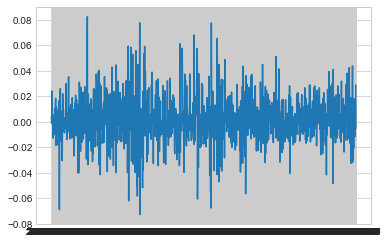

In [128]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(train_all['Timestamp'].values.tolist(), train_all['target'].values.tolist());
print(train_all['target'].mean())